# <a id='toc1_'></a>[sport-adverse-events](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [sport-adverse-events](#toc1_)    
  - [init code](#toc1_1_)    
  - [load data](#toc1_2_)    
    - [option clean csv](#toc1_2_1_)    
    - [option dirty csv](#toc1_2_2_)    
  - [arrange data](#toc1_3_)    
    - [trim column names](#toc1_3_1_)    
    - [set date column](#toc1_3_2_)    
    - [remove duplicates or invalids](#toc1_3_3_)    
    - [parse dates to datetime 🕥](#toc1_3_4_)    
  - [reduce data](#toc1_4_)    
    - [(optional) remove columns w/ no or few values](#toc1_4_1_)    
  - [show data](#toc1_5_)    
  - [💾 data for pivot use](#toc1_6_)    
  - [analysis showcase 📈](#toc1_7_)    
  - [interactive](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[init code](#toc0_)

In [28]:
import io
import os
from glob import glob
import pandas as pd
from pathlib import Path
from pandas_plots import tbl, pls
from connection_helper import pgp
from dotenv import load_dotenv, find_dotenv
import missingno as mi
import re

os.environ["THEME"]="light"

dir_data_in=Path("../data/in")
dir_data_out=Path("../data/out")

# ! only 1 csv file in in/ is allowed
file_csv_list=glob(f"{dir_data_in}/*.csv")
assert len(file_csv_list) == 1, f"❌ Expected 1 csv file, found {len(file_csv_list)}"

file_csv = file_csv_list[0]

## <a id='toc1_2_'></a>[load data](#toc0_)


### <a id='toc1_2_1_'></a>[option clean csv](#toc0_)

In [2]:
df_csv = pd.read_csv(file_csv, sep=",", encoding="utf-8-sig", dtype={"[01.01] Bewertung - CTCAE-Bewertung":str})

### <a id='toc1_2_2_'></a>[option dirty csv](#toc0_)
- ⚠️ strategy to import the csv raw data:
  - ❌ do not use default `pd.read_csv()`, its not as error tolerant as excel
  - ✅ read csv as `windows-1252` string and cleanse it
    - most (not all) lines have heading + trailing quotes, remove
    - data have a mixture of "" and ", downgrade by 1
    - delimiter "," also occurs in quotes, change to ";" only outside of quotes
    - now byte stream can be imported

In [3]:
%%script echo skipping

# * replace delimiter *only* outside of quotes
def replace_delimiter_outside_quotes(
    input: str, delimiter_old: str = ",", delimiter_new: str = ";", quotechar: str = '"'
):
    outside_quotes = True
    output = ""
    # * loop through input and toggle inside/outside status
    for char in input:
        if char == quotechar:
            outside_quotes = not outside_quotes
        elif outside_quotes and char == delimiter_old:
            char = delimiter_new
        output += char
    return output

# * downgrades quotes in string to normalize quots: " -> NA, "" -> "
def reduce_quotes_in_string(input: str):
    output = ""
    len_=len(input)
    i = 0
    while i < len_:
        # * check current + next char if within range
        if input[i] == '"' and i+1 < len_ and input[i+1] != '"':
            output += ''
            i = i+1
        elif input[i] == '"'and i+1 < len_ and input[i+1] == '"':
            output+= '"'
            i = i+2
        else:
            output += input[i]
            i=i+1
    return output

# * read csv -> variable
with open(file_csv, encoding="windows-1252") as f:
    csv=f.read()

# * selectively change , into ;
csv_lines = csv.splitlines()
csv_lines_new = []
for line in csv_lines[:]:
    # * remove first and last quotes if present
    if line[:1] == '"':
        line = line[1:-1]
    # * tailor line by line
    line=reduce_quotes_in_string(line)
    line=replace_delimiter_outside_quotes(line)
    # * just now quotes can be removed, not before
    line=line.replace('"', '')
    csv_lines_new.append(line)
    # print(f'{line.count(";")} {line}')

# * list -> string fo feed into df constructor
csv_string = "\n".join(csv_lines_new).replace('\t', '')

df_csv = pd.read_csv(
    io.StringIO(csv_string),
    sep=";",
    encoding="windows-1252",
)

Couldn't find program: 'echo'


## <a id='toc1_3_'></a>[arrange data](#toc0_)

### <a id='toc1_3_1_'></a>[trim column names](#toc0_)

In [4]:
cols_trimmed = [col.strip() for col in df_csv.columns]
df_csv.columns = cols_trimmed

### <a id='toc1_3_2_'></a>[set date column](#toc0_)

In [5]:
[print(col) for col in df_csv.columns if "Datum" in col]
col_date = "[02.01] Basics - Datum"

[02.01] Basics - Datum


### <a id='toc1_3_3_'></a>[remove duplicates or invalids](#toc0_)

In [6]:
# # * remove known erroruos lines
df_csv.drop([0,34,33], inplace=True, axis=0, errors='raise')
# * remove "löschen" lines
df_csv = df_csv[~(df_csv[col_date] == "löschen")]

In [7]:
df_csv

,Participant ID,Survey Identifier,Survey Timestamp,[02.01] Basics - Datum,[01.01] Bewertung - CTCAE-Bewertung,[01.02] Wann ist das AE erstmals aufgetreten?,"[01.03] Bewertung - Glauben Sie, dass das AE mit dem Sport assoziiert ist?",[02.02] Basics - Was war das AE? (choice=Schmerzen),[02.02] Basics - Was war das AE? (choice=Übelkeit/ Erbrechen),[02.02] Basics - Was war das AE? (choice=Oberflächliche Verletzungen),...,Welche motorische Hauptform dominierte die Bewegungseinheit ? (choice=Schnelligkeit).1,In welcher Phase der geplanten Sporteinheit trat das AE auf?.1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Gut).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Durchschnittlich).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Weiß nicht).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Anmerkung).1,"Glaubst Du, dass das AE mit dem Sport assoziiert ist?",Anmerkung.1,Complete?.2
1,3,NaN,2022-10-13 13:41:16,2022_10,2,Das AE war vor dem Sport bereits vorhanden und...,No,Unchecked,Checked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
2,4,NaN,2022-11-08 09:19:23,2022_10,1,Das AE ist neu aufgetreten.,Yes,Checked,Unchecked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
3,5,NaN,2022-11-08 09:31:05,2022_11,2,Das AE war vor dem Sport bereits vorhanden und...,No,Unchecked,Unchecked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
4,6,NaN,2022-11-18 10:10:55,2022_11,1,Das AE ist neu aufgetreten.,No,Unchecked,Checked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
5,7,NaN,2022-11-21 14:02:25,2022_11,3,Das AE ist neu aufgetreten.,Yes,Unchecked,Unchecked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,189,NaN,NaN,2024_09_12,NaN,Das AE war vor dem Sport bereits vorhanden und...,No,Unchecked,Checked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
185,190,NaN,NaN,2024_10_07,NaN,Das AE ist neu aufgetreten.,Yes,Unchecked,Unchecked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
186,191,NaN,NaN,2024_12_12,NaN,Das AE ist neu aufgetreten.,Yes,Checked,Unchecked,Checked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN
187,192,NaN,NaN,2025_01_10,NaN,Das AE war vor dem Sport bereits vorhanden und...,Yes,Checked,Unchecked,Unchecked,...,Unchecked,NaN,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,NaN,NaN


### <a id='toc1_3_4_'></a>[parse dates to datetime 🕥](#toc0_)

In [8]:
# %%script echo skipping

# * manual override of invalid dates
df_csv.loc[df_csv[col_date]=="2023_08_2028", col_date]="2023_08_28"
df_csv.loc[df_csv[col_date]=="2024_16", col_date]="2024_06"

# * split column into  all possible date patterns, these may not interfere!
# * parse date col
REG_DATE_YYYY_MM=r"\d{4}_\d{2}$"
REG_DATE_YYYY_MM_DD=r"\d{4}_\d{2}_\d{2}$"
REG_DATE_DD_MM_YYYY=r"\d{2}.\d{2}.\d{4}$"

# * get subsets according to regex
_df1=df_csv[df_csv[col_date].str.contains(REG_DATE_YYYY_MM, na=False)][col_date]
_df2=df_csv[df_csv[col_date].str.contains(REG_DATE_YYYY_MM_DD, na=False)][col_date]
_df3=df_csv[df_csv[col_date].str.contains(REG_DATE_DD_MM_YYYY, na=False)][col_date]

# * convert each to corresponding datetime
_df1=pd.to_datetime(_df1, format="%Y_%m").astype(str)
_df2=pd.to_datetime(_df2, format="%Y_%m_%d").astype(str)
_df3=pd.to_datetime(_df3, format="%d.%m.%Y").astype(str)

# * update in place
df_csv.update(_df1)
df_csv.update(_df2)
df_csv.update(_df3)

# * now convert the whole col
df_csv[col_date]=pd.to_datetime(df_csv[col_date], format='ISO8601')

# * blend timestamp into date column
df_csv[col_date].fillna(df_csv["Survey Timestamp"], inplace=True)

## <a id='toc1_4_'></a>[reduce data](#toc0_)

### <a id='toc1_4_1_'></a>[(optional) remove columns w/ no or few values](#toc0_)

In [9]:
import numpy as np
# * remove columns with no value
cols_no_value = [col for col in df_csv.columns if df_csv[col].isna().all()]
print("these columns have no values at all:")

print(np.array(cols_no_value))

# # ! remove columns
# cols_after_removal = list(set(df_csv.columns) - set(cols_no_value))
# df_csv = df_csv[list(set(df_csv.columns) - set(cols_no_value))]

these columns have no values at all:
['Survey Identifier'
 '[03.04.02] Folgen - Wie lange wurde der Zeitplan des Therapieprotokolls verzögert ?'
 '[03.05.01] Folgen - Wie oft wurde die lebensnotwendigen Intervention wiederholt?'
 '[07.05]: Weitere: Expertise' 'Erläutere Weitere' 'Survey Timestamp.1'
 'An welchem NAOK-Standort ist das AE aufgetreten?'
 'Erläuterung Sonstiges' 'Wie lange dauerte(n) die Konsequenz(en) an?'
 'Das AE ist durch den Sport neu aufgetreten.'
 'Das AE war vor dem Sport bereits bekannt.'
 'Bei welchem Anlass trat das AE auf?'
 'Wie alt war der/die Betroffene zum Zeitpunkt des AE?'
 'In welchem Setting ist das AE aufgetreten?' 'Erläuterung Sonstiges.1'
 'Was ist genau passiert?' 'Erläuterung Sonstiges.2'
 'In welcher Phase der geplanten Sporteinheit trat das AE auf?'
 'Anmerkung' 'Complete?.1' 'Survey Timestamp.2'
 'Was war das AE? (Schmerz, Schürfwunde etc.)'
 'Waren die Maßnahmen med. oder pädagogischer Natur?'
 'An welchem NAOK-Standort ist das AE aufgetreten?.

## <a id='toc1_5_'></a>[show data](#toc0_)

🔵 *** df: df_csv_short ***
🟣 shape: (185, 298) columns: ['Participant ID' 'Survey Identifier' 'Survey Timestamp'
 '[02.01] Basics - Datum' '[01.01] Bewertung - CTCAE-Bewertung'
 '[01.02] Wann ist das AE erstmals aufgetreten?'
 '[01.03] Bewertung - Glauben Sie, dass das AE mit dem Sport assoziiert ist?'
 '[02.02] Basics - Was war das AE?  (choice=Schmerzen)'
 '[02.02] Basics - Was war das AE?  (choice=Übelkeit/ Erbrechen)'
 '[02.02] Basics - Was war das AE?  (choice=Oberflächliche Verletzungen)'
 '[02.02] Basics - Was war das AE?  (choice=Kreislaufprobleme)'
 '[02.02] Basics - Was war das AE?  (choice=Knochenverletzungen)'
 '[02.02] Basics - Was war das AE?  (choice=Starke Erschöpfung)'
 '[02.02] Basics - Was war das AE?  (choice=Hustenanfall)'
 '[02.02] Basics - Was war das AE?  (choice=Enuresis)'
 '[02.02] Basics - Was war das AE?  (choice=Juckreiz)'
 '[02.02] Basics - Was war das AE?  (choice=Psychische Stressreaktion)'
 '[02.02] Basics - Was war das AE?  (choice=Nasenbluten)'
 '[02.

,Participant ID,Survey Identifier,Survey Timestamp,[02.01] Basics - Datum,[01.01] Bewertung - CTCAE-Bewertung,[01.02] Wann ist das AE erstmals aufgetreten?,"[01.03] Bewertung - Glauben Sie, dass das AE mit dem Sport assoziiert ist?",[02.02] Basics - Was war das AE? (choice=Schmerzen),[02.02] Basics - Was war das AE? (choice=Übelkeit/ Erbrechen),[02.02] Basics - Was war das AE? (choice=Oberflächliche Verletzungen),...,Welche motorische Hauptform dominierte die Bewegungseinheit ? (choice=Schnelligkeit).1,In welcher Phase der geplanten Sporteinheit trat das AE auf?.1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Gut).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Durchschnittlich).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Mäßig).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Weiß nicht).1,Welchen Trainingszustand hatte der / die Betroffene zum Zeitpunkt als das AE auftrat? (choice=Anmerkung).1,"Glaubst Du, dass das AE mit dem Sport assoziiert ist?",Anmerkung.1,Complete?.2
1,3,nan,2022-10-13 13:41:16,2022-10-01,2,Das AE war vor dem Sport bereits vorhanden und...,No,Unchecked,Checked,Unchecked,...,Unchecked,nan,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,nan,nan,nan
2,4,nan,2022-11-08 09:19:23,2022-10-01,1,Das AE ist neu aufgetreten.,Yes,Checked,Unchecked,Unchecked,...,Unchecked,nan,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,nan,nan,nan
3,5,nan,2022-11-08 09:31:05,2022-11-01,2,Das AE war vor dem Sport bereits vorhanden und...,No,Unchecked,Unchecked,Unchecked,...,Unchecked,nan,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,nan,nan,nan


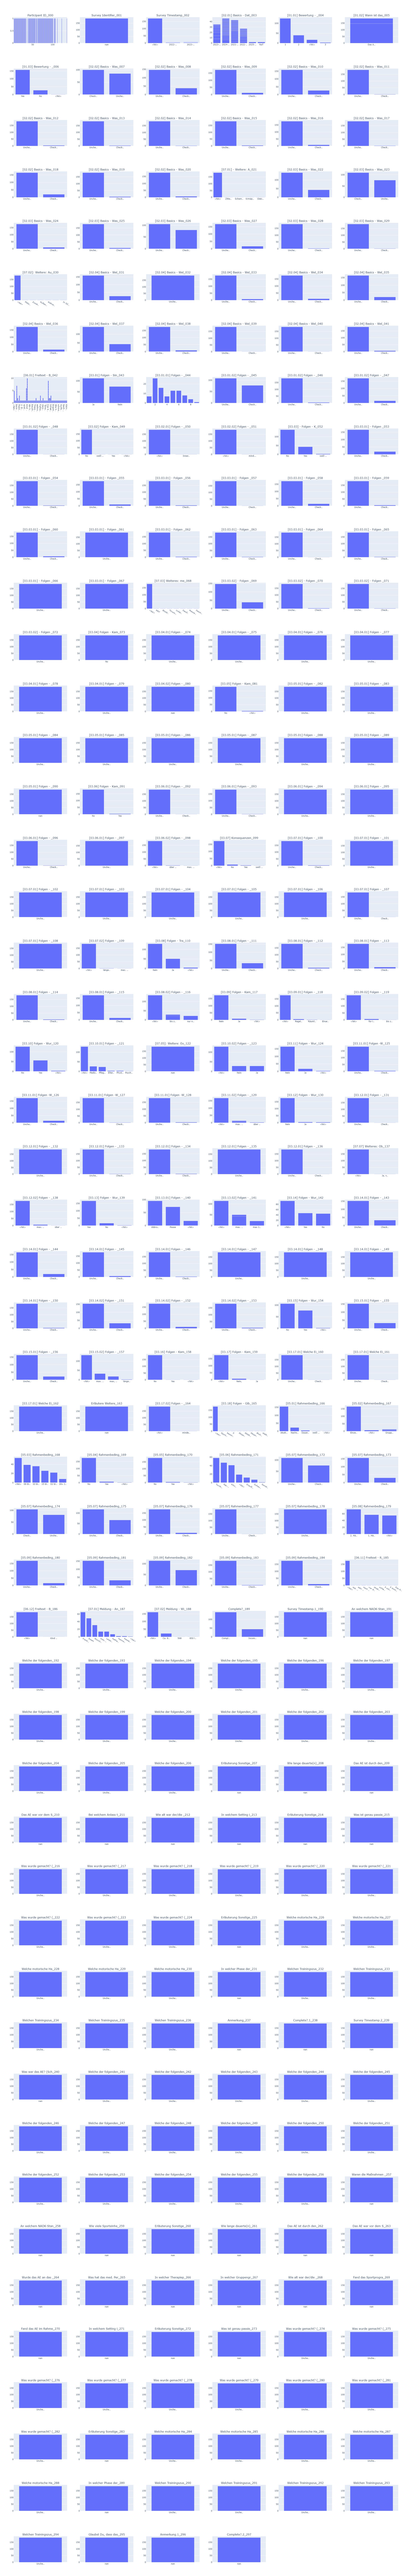

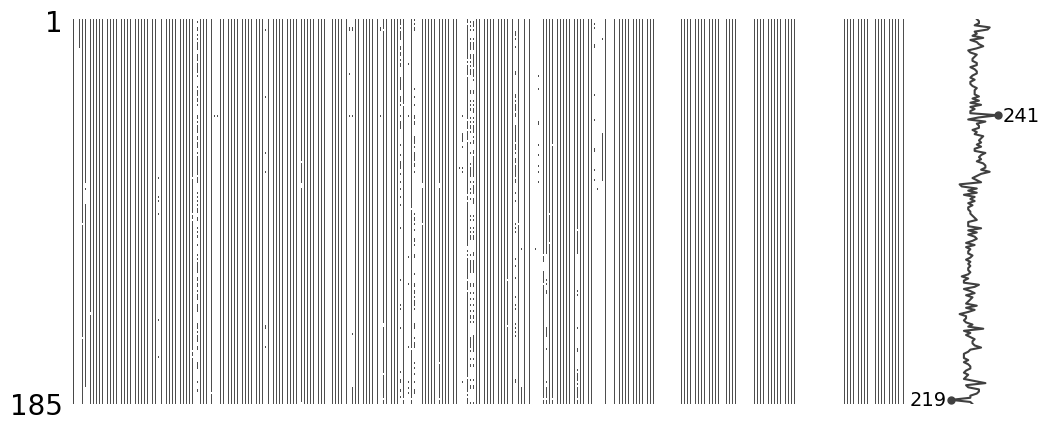

In [31]:
# # * only show cols w/ >1 value
df_csv_short = df_csv.loc[:, df_csv.apply(pd.Series.nunique) > 1]

tbl.describe_df(df_csv.iloc[:,:], "df_csv_short", top_n_uniques=5, top_n_chars_in_index=5, use_plot=True, top_n_chars_in_columns=20, use_missing=True, fig_cols=6)

## <a id='toc1_6_'></a>[💾 data for pivot use](#toc0_)

In [11]:
df_csv_short.reset_index().to_csv(Path(dir_data_out/"df_csv.csv"),sep=";", index=False, encoding="utf-8-sig")
df_csv_short.reset_index().to_excel(Path(dir_data_out/"df_csv.xlsx"), index=False)

## <a id='toc1_7_'></a>[analysis showcase 📈](#toc0_)

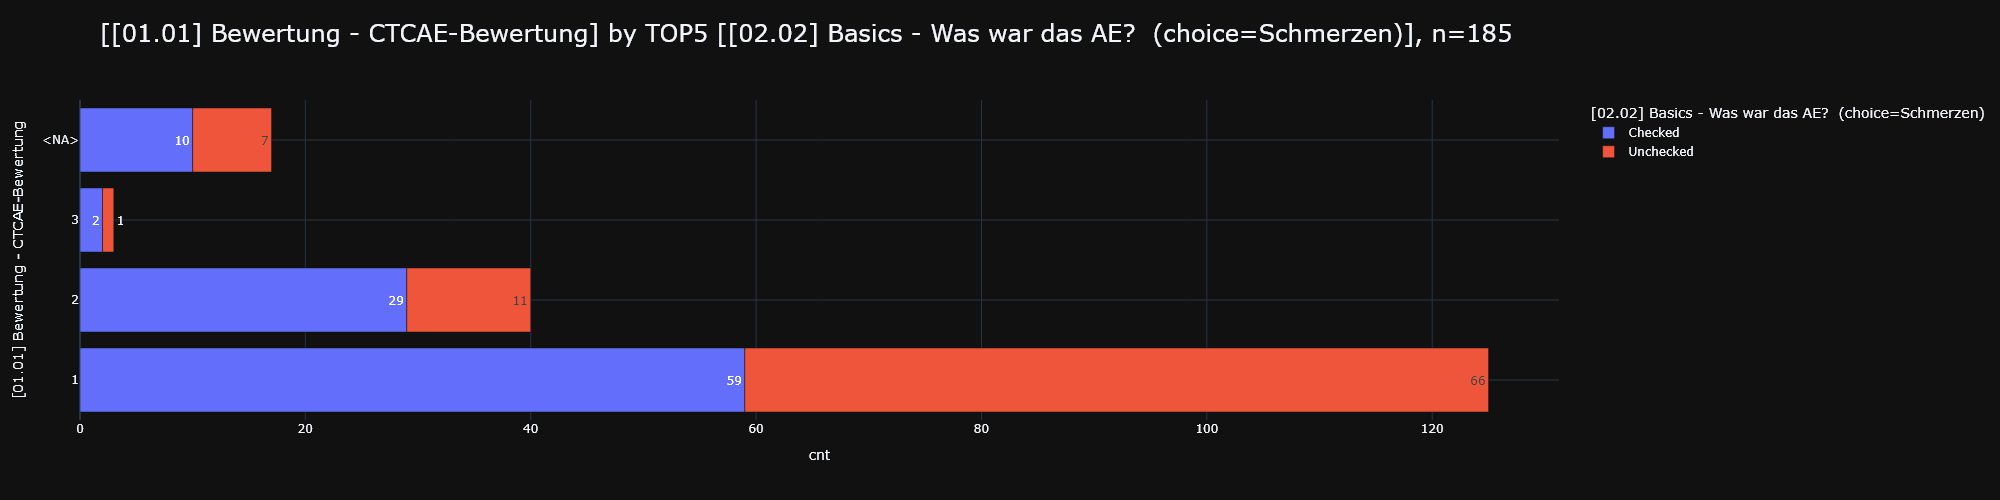

In [12]:
df_csv_short.columns
_df = df_csv[[
    "[01.01] Bewertung - CTCAE-Bewertung", 
    "[02.02] Basics - Was war das AE?  (choice=Schmerzen)"
    ]]
_=pls.plot_stacked_bars(
    _df,
    dropna=False,
    top_n_color=5,
    orientation="h"
)

In [13]:
filtered_cols = [col for col in df_csv_short.columns if 'CTCAE' in col]
print(filtered_cols)

['[01.01] Bewertung - CTCAE-Bewertung']


In [29]:

_df = df_csv[[
    "[05.03] Rahmenbedingungen - Wie alt war der/die Betroffene zum Zeitpunkt des AE?", 
    "[01.01] Bewertung - CTCAE-Bewertung"
    ]]
_=pls.plot_stacked_bars(
    _df,
    dropna=False,
    top_n_color=5,
    orientation="v",
    renderer=None,
    relative=True,
    height=800,
    # show_total=True
    )
tbl.pivot_df(_df)

[01.01] Bewertung - CTCAE-Bewertung,1,2,3,,Total
[05.03] Rahmenbedingungen - Wie alt war der/die Betroffene zum Zeitpunkt des AE?,,,,,
02 bis 5 Jahre,13 (7.0%),8 (4.3%),0,1 (0.5%),22 (11.9%)
06 bis 9 Jahre,29 (15.7%),4 (2.2%),0,6 (3.2%),39 (21.1%)
10 bis 14 Jahre,22 (11.9%),8 (4.3%),0,6 (3.2%),36 (19.5%)
15 bis 18 Jahre,16 (8.6%),6 (3.2%),1 (0.5%),3 (1.6%),26 (14.1%)
18+ Jahre,3 (1.6%),3 (1.6%),2 (1.1%),0,8 (4.3%)
,42 (22.7%),11 (5.9%),0,1 (0.5%),54 (29.2%)
Total,125 (67.6%),40 (21.6%),3 (1.6%),17 (9.2%),185 (100.0%)


## <a id='toc1_8_'></a>[interactive](#toc0_)

In [15]:
if False:
    import pygwalker as pyg

    _=pyg.walk(df_csv)